In [1]:
from __future__ import division

import urllib
import os
import glob
import random
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D, Dropout
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

import utils
from scipy import ndimage 

Using TensorFlow backend.


In [2]:
image_size = (512,512)
n_slices = 32
ratio = (1, 1)
gray = False

## Load Training Images

In [52]:
CORPUS_PATH = "data/train/"
TEST_PATH = "data/test/"
OUTPUT_PATH = "output"

In [4]:
classes = os.listdir(CORPUS_PATH)

image_list = []
label_list = []

for label, c in enumerate(classes):
    print(c)
    terrain_path = os.path.join(CORPUS_PATH, c)
    for f_name in os.listdir(terrain_path):
        img = cv2.imread(os.path.join(terrain_path, f_name))
        if gray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
        img_resize = cv2.resize(img, image_size)
        slices = utils.prepare_images(img_resize, image_size, ratio, n_slices)
        if gray:
            slices = np.expand_dims(slices, -1)
        image_list.append(slices)
        label_list.append(np.full((slices.shape[0]), label))
        
X_train = np.concatenate(image_list)
labels = np.concatenate(label_list)
one_hot_labels = to_categorical(labels, num_classes=len(classes))

vegetation
water
desert
clouds


In [5]:
X_train.shape

(165888, 16, 16, 3)

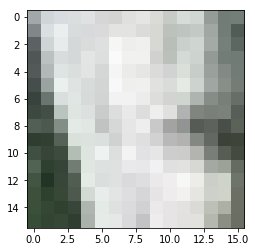

In [6]:
plt.imshow(X_train[15, :, :])

## Create Model

In [7]:
if gray:
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
else:
    input_shape = (X_train.shape[1], X_train.shape[2], 3)

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

opt = optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Train Model

In [9]:
history = model.fit(X_train, one_hot_labels, epochs=5, batch_size=2056)

Epoch 1/5
165888/165888 [==============================] - 13s - loss: 1.7535 - acc: 0.6087    
Epoch 2/5
165888/165888 [==============================] - 9s - loss: 0.6151 - acc: 0.7779     
Epoch 3/5
165888/165888 [==============================] - 9s - loss: 0.6297 - acc: 0.7986     
Epoch 4/5
165888/165888 [==============================] - 9s - loss: 0.4579 - acc: 0.8485     
Epoch 5/5
165888/165888 [==============================] - 9s - loss: 0.3930 - acc: 0.8675     


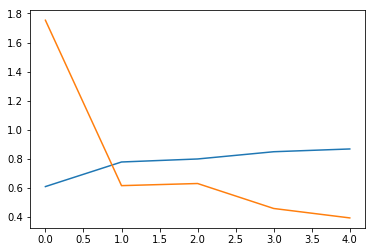

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])

## Read test images

In [11]:
def download_image(url, file_name):
    return urllib.urlretrieve(url, file_name)

In [148]:
with open("test_images.txt", 'r') as f:
    image_urls = f.read().split("\n")

In [149]:
for i, image_url in enumerate(image_urls):
    download_image(image_url, os.path.join(TEST_PATH, str(i)))

In [53]:
image_list = []
gray_list = []
for f_name in os.listdir(TEST_PATH):
    img = cv2.imread(os.path.join(TEST_PATH, f_name))    
    if gray:
        img = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)

    img_resize = cv2.resize(img, image_size)
    slices = utils.prepare_images(img_resize, image_size, ratio, n_slices)
    gray_list.append(np.expand_dims(slices, -1))
    image_list.append(img_resize)
    
images = np.stack(image_list)
X = np.stack(gray_list)
X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3], X.shape[4])

In [54]:
X.shape

(57344, 16, 16, 3)

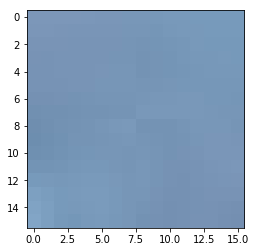

In [55]:
plt.imshow(X[0,:, :])

## Predict Labels

vegetation

water

desert

clouds

In [56]:
preds = model.predict(X)

In [57]:
labels = np.argmax(preds, axis=1)

In [58]:
labels = np.reshape(labels, (len(images), n_slices, n_slices))

## Visualize Predictions

In [59]:
colors = [(124,252,0), (244,164,96),(0,191,255), (255, 255, 255)]

In [60]:
percentages = []

for i, (img, l) in enumerate(zip(images, labels)):
    assignment_mask = np.zeros((l.shape[0], l.shape[1], 3))
    percentages.append(np.bincount(l.flatten()) / l.size)
    for label in xrange(len(classes)):
        assignment_mask[np.isin(l, label)] = colors[label]
        
    alpha = 0.5
    output = img.copy()
    output = output.astype('uint8')
    assignment_mask = assignment_mask.astype('uint8')
    assignment_mask = cv2.resize(assignment_mask, image_size, interpolation=cv2.INTER_CUBIC)
    assignment_mask = cv2.flip(ndimage.rotate(assignment_mask, 90),0)
    overlay = assignment_mask
    output = cv2.addWeighted(overlay, alpha, output, 1 - alpha,
                    0, output)
    cv2.imwrite(os.path.join(OUTPUT_PATH, "{}.jpg".format(i)), img)
    cv2.imwrite(os.path.join(OUTPUT_PATH, "{}_overlay.jpg".format(i)), output)
    cv2.imwrite(os.path.join(OUTPUT_PATH, "{}_labels.jpg".format(i)), assignment_mask)

In [61]:
percentages

[array([  0.00000000e+00,   0.00000000e+00,   9.99023438e-01,
          9.76562500e-04]),
 array([ 0.,  0.,  1.]),
 array([ 0.        ,  0.        ,  0.99804688,  0.00195312]),
 array([ 0.01367188,  0.00683594,  0.68457031,  0.29492188]),
 array([ 0.00292969,  0.        ,  0.69042969,  0.30664062]),
 array([ 0.15332031,  0.05078125,  0.72363281,  0.07226562]),
 array([ 0.54296875,  0.22558594,  0.05371094,  0.17773438]),
 array([ 0.19433594,  0.34863281,  0.24609375,  0.2109375 ]),
 array([ 0.00878906,  0.        ,  0.91308594,  0.078125  ]),
 array([ 0.09667969,  0.84472656,  0.02832031,  0.03027344]),
 array([ 0.,  1.]),
 array([ 0.16015625,  0.02929688,  0.73339844,  0.07714844]),
 array([ 0.40820312,  0.50585938,  0.06347656,  0.02246094]),
 array([ 0.      ,  0.515625,  0.      ,  0.484375]),
 array([ 0.00292969,  0.03808594,  0.30175781,  0.65722656]),
 array([ 0.41015625,  0.09277344,  0.2421875 ,  0.25488281]),
 array([ 0.43554688,  0.06445312,  0.00976562,  0.49023438]),
 arra

In [48]:
classes

['vegetation', 'water', 'desert', 'clouds']

In [49]:
percentages

[array([ 0.00097656,  0.04101562,  0.84765625,  0.11035156]),
 array([ 0.00097656,  0.12402344,  0.61816406,  0.25683594]),
 array([ 0.00292969,  0.11621094,  0.87011719,  0.01074219]),
 array([ 0.        ,  0.10253906,  0.86425781,  0.03320312]),
 array([ 0.00097656,  0.07226562,  0.91796875,  0.00878906]),
 array([ 0.00097656,  0.10742188,  0.84082031,  0.05078125]),
 array([ 0.00097656,  0.08691406,  0.88964844,  0.02246094]),
 array([ 0.00097656,  0.04199219,  0.95117188,  0.00585938]),
 array([ 0.00292969,  0.10742188,  0.87988281,  0.00976562]),
 array([ 0.01269531,  0.046875  ,  0.87011719,  0.0703125 ]),
 array([ 0.00292969,  0.14550781,  0.83496094,  0.01660156]),
 array([ 0.00195312,  0.08398438,  0.80566406,  0.10839844]),
 array([ 0.        ,  0.10546875,  0.88867188,  0.00585938]),
 array([ 0.00097656,  0.09960938,  0.89941406]),
 array([ 0.00195312,  0.09179688,  0.88574219,  0.02050781]),
 array([ 0.00097656,  0.07324219,  0.91015625,  0.015625  ]),
 array([ 0.        , 

In [38]:
percentages

[array([ 0.94628906,  0.01171875,  0.        ,  0.04199219]),
 array([ 0.91503906,  0.02636719,  0.00878906,  0.04980469]),
 array([ 0.92089844,  0.00878906,  0.01269531,  0.05761719]),
 array([ 0.94042969,  0.01171875,  0.00195312,  0.04589844]),
 array([ 0.97753906,  0.00292969,  0.00195312,  0.01757812]),
 array([ 0.93066406,  0.00683594,  0.00488281,  0.05761719]),
 array([ 0.97949219,  0.015625  ,  0.        ,  0.00488281]),
 array([  9.98046875e-01,   9.76562500e-04,   0.00000000e+00,
          9.76562500e-04]),
 array([ 0.95898438,  0.00488281,  0.00292969,  0.03320312]),
 array([ 0.88671875,  0.01074219,  0.        ,  0.10253906]),
 array([ 0.96972656,  0.00488281,  0.00097656,  0.02441406]),
 array([ 0.96386719,  0.00195312,  0.        ,  0.03417969])]

In [27]:
percentages

[array([ 0.        ,  0.90917969,  0.00097656,  0.08984375]),
 array([ 0.        ,  0.80859375,  0.01953125,  0.171875  ]),
 array([ 0.        ,  0.69042969,  0.02636719,  0.28320312]),
 array([ 0.        ,  0.58203125,  0.03417969,  0.38378906]),
 array([ 0.        ,  0.94628906,  0.00390625,  0.04980469]),
 array([ 0.        ,  0.88574219,  0.        ,  0.11425781]),
 array([ 0.     ,  0.90625,  0.     ,  0.09375]),
 array([ 0.        ,  0.90039062,  0.00976562,  0.08984375]),
 array([ 0.        ,  0.82714844,  0.02832031,  0.14453125]),
 array([ 0.        ,  0.87597656,  0.00976562,  0.11425781]),
 array([ 0.        ,  0.87207031,  0.0078125 ,  0.12011719]),
 array([ 0.        ,  0.75195312,  0.02050781,  0.22753906]),
 array([ 0.        ,  0.66308594,  0.01464844,  0.32226562]),
 array([ 0.        ,  0.6640625 ,  0.00195312,  0.33398438]),
 array([ 0.        ,  0.81640625,  0.01269531,  0.17089844]),
 array([ 0.        ,  0.65625   ,  0.02832031,  0.31542969]),
 array([ 0.        ,